<a href="https://colab.research.google.com/github/mafaves/AI-projects/blob/main/image_dataset/Chest_X-Ray_Images_Pneumonia/transfer_learning_cnn_x_chest_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRANSFER LEARNING

https://github.com/krishnaik06/Deep-Learning-in-Medical-Science/blob/master/Lungs.py

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob
import zipfile
import os

#import image libraries
import cv2
import PIL

#import tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential


## DOWNLOADING DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#path to the kaggle.json directory
path_API_autentification_token= '/content/drive/MyDrive/Colab_Notebooks/master/Chest_X_Ray_Images_Pneumonia'

In [ ]:
# Coping the kaggle API to the Google Colab
os.environ['KAGGLE_CONFIG_DIR'] = path_API_autentification_token

# Downloading the data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzziping the data and storing into /tmp
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

 99% 2.28G/2.29G [00:34<00:00, 147MB/s]
100% 2.29G/2.29G [00:34<00:00, 72.2MB/s]


In [ ]:
# Define the path to the extracted directory
extracted_dir = '/tmp/chest_xray'

# List the contents of the directory
contents = os.listdir(extracted_dir)

# Print the contents
print(contents)

['chest_xray', 'train', '__MACOSX', 'test', 'images', 'val']


## DATA PREPARATION

The downloaded data contain 3 main folders: 'test', 'val' and 'test'. Inside each one, there are two subcategories: 'NORMAL' and 'PNEUMONIA'.

 In this case, I prefer to only have two: 'NORMAL' and 'PNEUMONIA' (I prefer it in order to manage all images with tf)

In [ ]:
import os
import shutil

def move_files(src_path, dest_path):
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)

    for filename in os.listdir(src_path):
        file_path = os.path.join(src_path, filename)
        shutil.move(file_path, os.path.join(dest_path, filename))

extracted_dir = '/tmp/chest_xray'
main_folders = ['train', 'val', 'test']
output_folders = ['NORMAL', 'PNEUMONIA']

# Move files from subfolders to main folders
for main_folder in main_folders:
    for output_folder in output_folders:
        move_files(os.path.join(extracted_dir, main_folder, output_folder), os.path.join(extracted_dir, output_folder))

# Print the number of files in 'NORMAL' and 'PNEUMONIA' folders
for folder_name in ['NORMAL', 'PNEUMONIA']:
    folder_path = os.path.join(extracted_dir, folder_name)
    file_count = len(os.listdir(folder_path))
    print(f"Number of files in '{folder_name}' folder: {file_count}")

# Move 'NORMAL' and 'PNEUMONIA' folders into the 'images' folder
images_dir = os.path.join(extracted_dir, 'images')
move_files(os.path.join(extracted_dir, 'NORMAL'), os.path.join(images_dir, 'NORMAL'))
move_files(os.path.join(extracted_dir, 'PNEUMONIA'), os.path.join(images_dir, 'PNEUMONIA'))

print("Folders moved successfully.")

## PREPROCESSING IMAGES

In [ ]:
# Define the path to the extracted directory
extracted_dir = '/tmp/chest_xray/images'
# List the contents of the directory
contents = os.listdir(extracted_dir)

# Print the contents
print(contents)

['NORMAL', 'PNEUMONIA']


In [ ]:
#Define image sizes
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=10

#### LOAD DATASET

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/tmp/chest_xray/images',
    #color_mode = 'grayscale',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5856 files belonging to 2 classes.


In [ ]:
# Get the number of batches in the dataset
num_batches = tf.data.experimental.cardinality(dataset).numpy()
print("Number of batches:", num_batches)

Number of batches: 183


In [ ]:
# Print the first batch of data
for images, labels in dataset.take(1):
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    print("Example labels:", labels.numpy())

Batch of images shape: (32, 224, 224, 3)
Batch of labels shape: (32,)
Example labels: [1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0]


In [ ]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

### Function to Split Dataset

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## BUILDING MODEL

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]


In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(1, activation='sigmoid')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
# fit the model
r = model.fit_generator(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  #steps_per_epoch=20,
  #validation_steps=5
)

Epoch 1/5


<ipython-input-23-1ccab3b39c39>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


146/146 [==============================] - 111s 401ms/step - loss: 2.5313 - accuracy: 0.9292 - val_loss: 0.1065 - val_accuracy: 0.9583
Epoch 2/5
146/146 [==============================] - 19s 131ms/step - loss: 0.0943 - accuracy: 0.9670 - val_loss: 0.0851 - val_accuracy: 0.9566
Epoch 3/5
146/146 [==============================] - 20s 136ms/step - loss: 0.0638 - accuracy: 0.9765 - val_loss: 0.0447 - val_accuracy: 0.9826
Epoch 4/5
146/146 [==============================] - 20s 134ms/step - loss: 0.0489 - accuracy: 0.9807 - val_loss: 0.0648 - val_accuracy: 0.9774
Epoch 5/5
146/146 [==============================] - 20s 138ms/step - loss: 0.0317 - accuracy: 0.9878 - val_loss: 0.0346 - val_accuracy: 0.9913


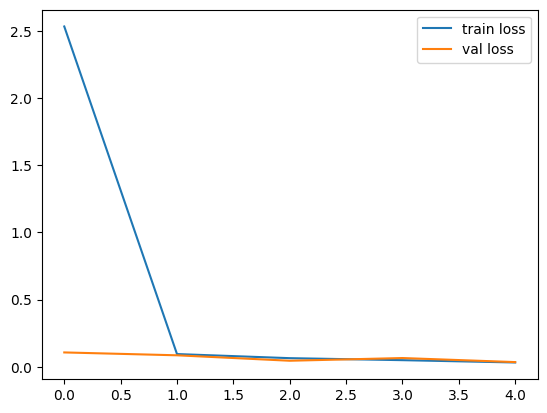

<Figure size 640x480 with 0 Axes>

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


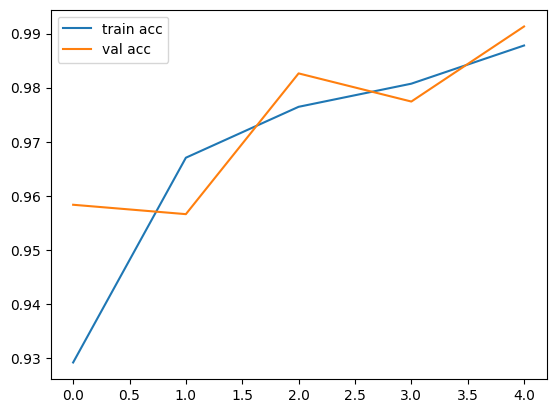

<Figure size 640x480 with 0 Axes>

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

#### Classification report

In [ ]:
# Make sure you haven't overwritten the classification_report function
from sklearn.metrics import classification_report

In [ ]:
# Mendefinisikan fungsi untuk membuat prediksi
def predict_and_evaluate(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi

    # Iterasi melalui dataset untuk mendapatkan label sebenarnya dan hasil prediksi
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    # Menghasilkan classification report
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])

    return report

In [ ]:
# Membuat classification report
classification_report = predict_and_evaluate(model, test_ds)

# Menampilkan classification report
print(classification_report)

              precision    recall  f1-score   support

      normal       0.96      0.98      0.97       173
   pneumonia       0.99      0.98      0.99       435

    accuracy                           0.98       608
   macro avg       0.98      0.98      0.98       608
weighted avg       0.98      0.98      0.98       608



#### Confusion matrix

In [ ]:
def calculate_confusion_matrix(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi

    # Iterasi melalui dataset untuk mendapatkan label sebenarnya dan hasil prediksi
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    # Menghitung confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    #Plot confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Ekstraksi TP, FP, TN, FN
    #gunakan ravel() atau flatten() untuk mendapatkan array satu dimensi
    tn, fp, fn, tp = conf_matrix.ravel()
    #tp = conf_matrix[1, 1]
    #p = conf_matrix[0, 1]
    #tn = conf_matrix[0, 0]
    #fn = conf_matrix[1, 0]

    return tp, fp, tn, fn

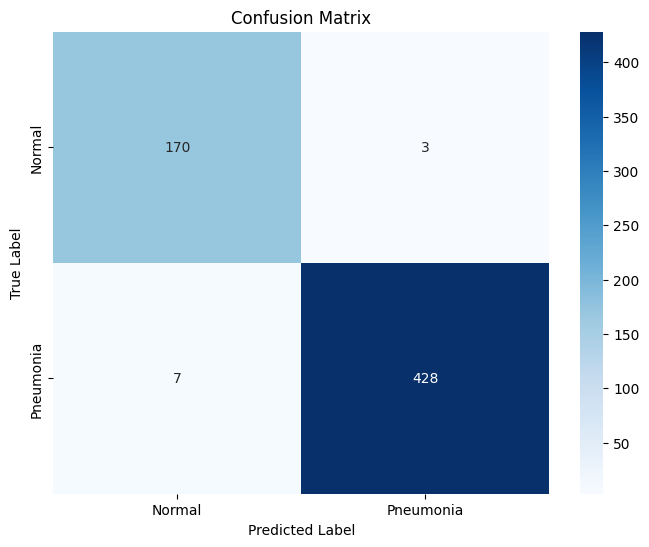

True Positive (TP): 428
False Positive (FP): 3
True Negative (TN): 170
False Negative (FN): 7


In [ ]:
# Menghitung confusion matrix dari model terload dan dataset test
tp, fp, tn, fn = calculate_confusion_matrix(model, test_ds)

# Menampilkan hasil
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)